# Text Classification in Cross-Validation using PAC Algorithm

## Import Libraries

In [1]:
import re
import unicodedata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from lime import lime_text
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.pipeline import make_pipeline
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.linear_model import PassiveAggressiveClassifier

## Set Hyparameters

In [2]:
C=1.0
tol=0.001

nfold=10

number_of_feature = 5000

dataset_path = "../input/politica/politica.xlsx"

## Load Dataset

In [3]:
df = pd.read_excel(dataset_path, sheet_name="Foglio1")
print(f'Found {len(df)} texts.')

print(f'{df["cap_maj_master"].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df['cap_maj_master'])]

print(f'{df["testo"].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df['testo'])]

classes = [int(c) for c in df['cap_maj_master']]
documents = [d for d in df['testo']]

###### Print dataset ###################
df = df[['cap_maj_master', 'testo']]
df.columns = ['sentiment', 'review']
df.head(3)

Found 5674 texts.
2 document(s) with no classification removed
424 document(s) with no text removed


,sentiment,review
0,1.0,: quali siano le determinazioni del Governo in...
1,1.0,: quali siano le valutazioni del Governo sugli...
2,1.0,- premesso che: la prospettata modifica degli ...


## Class Distribution Diagram

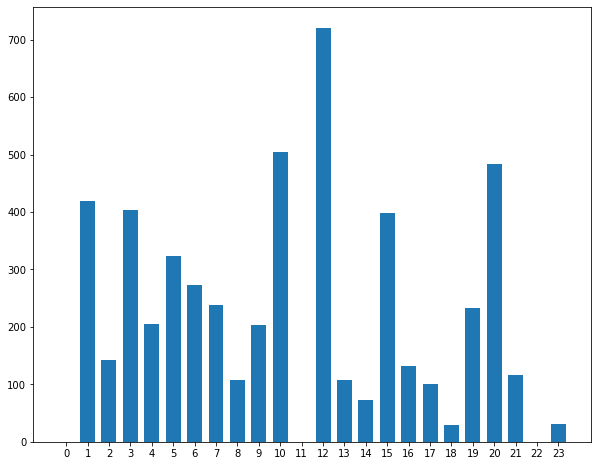

In [4]:
y = np.bincount(classes)
x = np.arange(len(y))
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()

## Define Preprocessor

In [5]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):
    
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words('italian'))

def tokenizer_porter(text):
    word_tokens = word_tokenize(text)
    stemmer = SnowballStemmer("italian", ignore_stopwords=True)
    return [stemmer.stem(word) for word in word_tokens]

## Define Infogain Function

In [6]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class IG():
    def __init__(self,k_features):
        self.k_features = k_features
        

    
    def fit(self, X, y):
        def _calIg():
            entropy_x_set = 0
            entropy_x_not_set = 0
            for c in classCnt:
                probs = classCnt[c] / float(featureTot)
                entropy_x_set = entropy_x_set - probs * np.log(probs)
                probs = (classTotCnt[c] - classCnt[c]) / float(tot - featureTot)
                entropy_x_not_set = entropy_x_not_set - probs * np.log(probs)
            for c in classTotCnt:
                if c not in classCnt:
                    probs = classTotCnt[c] / float(tot - featureTot)
                    entropy_x_not_set = entropy_x_not_set - probs * np.log(probs)
            return entropy_before - ((featureTot / float(tot)) * entropy_x_set
                             +  ((tot - featureTot) / float(tot)) * entropy_x_not_set)
        tot = X.shape[0]
        classTotCnt = {}
        entropy_before = 0
        for i in y:
            if i not in classTotCnt:
                classTotCnt[i] = 1
            else:
                classTotCnt[i] = classTotCnt[i] + 1
        for c in classTotCnt:
            probs = classTotCnt[c] / float(tot)
            entropy_before = entropy_before - probs * np.log(probs)

        nz = X.T.nonzero()
        pre = 0
        classCnt = {}
        featureTot = 0
        information_gain = []
        for i in range(0, len(nz[0])):
            if (i != 0 and nz[0][i] != pre):
                for notappear in range(pre+1, nz[0][i]):
                    information_gain.append(0)
                ig = _calIg()
                information_gain.append(ig)
                pre = nz[0][i]
                classCnt = {}
                featureTot = 0
            featureTot = featureTot + 1
            yclass = y[nz[1][i]]
            if yclass not in classCnt:
                classCnt[yclass] = 1
            else:
                classCnt[yclass] = classCnt[yclass] + 1
        ig = _calIg()
        information_gain.append(ig)
        information_gain_a=np.asarray(information_gain)
        self.indices_ = np.argsort(information_gain_a)[-self.k_features:]
        return self

    def transform(self, X):
        return X[:, self.indices_]

## Cross-Validation Pipeline

Feature trovati: 8432
Feature usati: 5000
--------------- Fold:  1 ---------------------

Accuracy: 0.72
Detail:
              precision    recall  f1-score   support

           1       0.57      0.64      0.61        42
           2       0.73      0.73      0.73        15
           3       0.92      0.82      0.87        40
           4       0.95      0.90      0.93        21
           5       0.64      0.66      0.65        32
           6       0.88      0.81      0.85        27
           7       0.88      0.88      0.88        24
           8       0.67      0.73      0.70        11
           9       0.62      0.75      0.68        20
          10       0.74      0.92      0.82        50
          12       0.76      0.74      0.75        73
          13       0.75      0.55      0.63        11
          14       1.00      0.43      0.60         7
          15       0.60      0.60      0.60        40
          16       0.67      0.77      0.71        13
          17       0.7

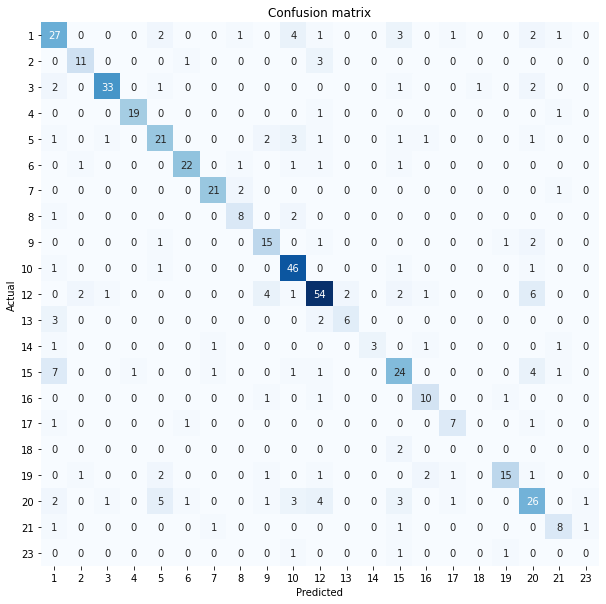

Feature trovati: 8461
Feature usati: 5000
--------------- Fold:  2 ---------------------

Accuracy: 0.68
Detail:
              precision    recall  f1-score   support

           1       0.53      0.43      0.47        42
           2       0.53      0.53      0.53        15
           3       0.81      0.88      0.84        40
           4       0.74      0.81      0.77        21
           5       0.55      0.53      0.54        32
           6       0.79      0.81      0.80        27
           7       0.85      0.92      0.88        24
           8       0.62      0.91      0.74        11
           9       0.60      0.60      0.60        20
          10       0.81      0.88      0.85        50
          12       0.72      0.72      0.72        72
          13       0.78      0.64      0.70        11
          14       0.71      0.71      0.71         7
          15       0.58      0.45      0.51        40
          16       0.69      0.85      0.76        13
          17       0.5

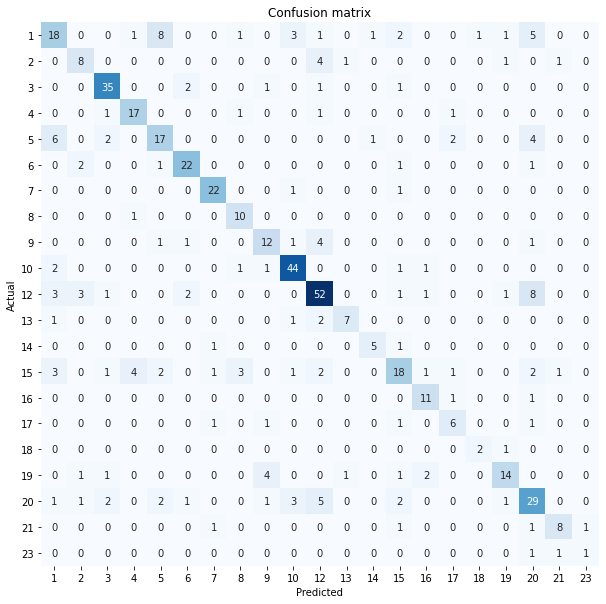

Feature trovati: 8456
Feature usati: 5000
--------------- Fold:  3 ---------------------

Accuracy: 0.66
Detail:
              precision    recall  f1-score   support

           1       0.49      0.52      0.51        42
           2       0.64      0.47      0.54        15
           3       0.75      0.90      0.82        40
           4       0.94      0.80      0.86        20
           5       0.62      0.70      0.66        33
           6       0.81      0.79      0.80        28
           7       0.80      0.67      0.73        24
           8       0.75      0.82      0.78        11
           9       0.86      0.60      0.71        20
          10       0.89      0.78      0.83        50
          12       0.70      0.79      0.74        72
          13       0.46      0.55      0.50        11
          14       0.60      0.43      0.50         7
          15       0.41      0.45      0.43        40
          16       0.83      0.77      0.80        13
          17       0.6

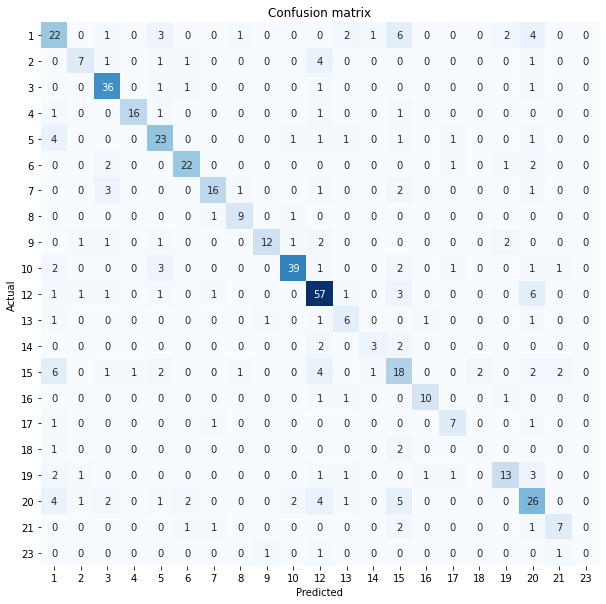

Feature trovati: 8458
Feature usati: 5000
--------------- Fold:  4 ---------------------

Accuracy: 0.7
Detail:
              precision    recall  f1-score   support

           1       0.59      0.55      0.57        42
           2       0.90      0.64      0.75        14
           3       0.86      0.80      0.83        40
           4       0.65      0.75      0.70        20
           5       0.63      0.73      0.68        33
           6       0.80      0.86      0.83        28
           7       0.78      0.88      0.82        24
           8       0.67      0.73      0.70        11
           9       0.74      0.70      0.72        20
          10       0.92      0.88      0.90        50
          12       0.71      0.78      0.74        72
          13       0.56      0.45      0.50        11
          14       0.67      0.29      0.40         7
          15       0.52      0.55      0.54        40
          16       0.65      0.85      0.73        13
          17       0.83

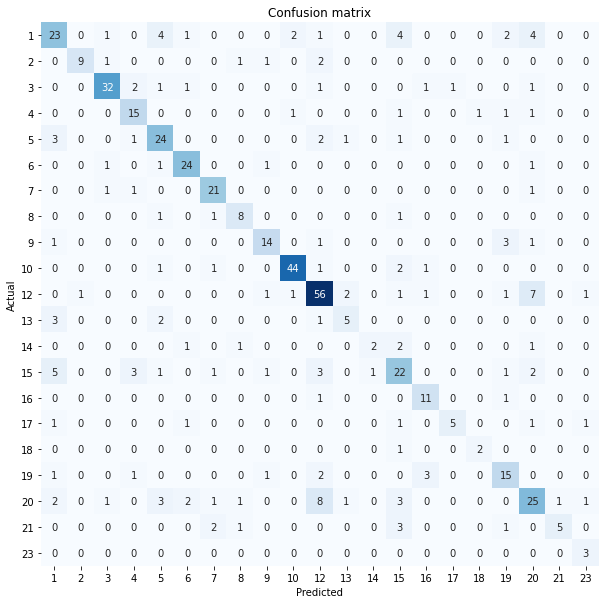

Feature trovati: 8472
Feature usati: 5000
--------------- Fold:  5 ---------------------

Accuracy: 0.7
Detail:
              precision    recall  f1-score   support

           1       0.59      0.55      0.57        42
           2       0.33      0.43      0.38        14
           3       0.89      0.85      0.87        40
           4       0.74      0.85      0.79        20
           5       0.66      0.70      0.68        33
           6       0.76      0.89      0.82        28
           7       0.80      0.70      0.74        23
           8       0.77      0.91      0.83        11
           9       0.74      0.70      0.72        20
          10       0.87      0.92      0.89        50
          12       0.80      0.74      0.77        72
          13       0.70      0.64      0.67        11
          14       1.00      0.71      0.83         7
          15       0.52      0.57      0.55        40
          16       0.64      0.64      0.64        14
          17       0.64

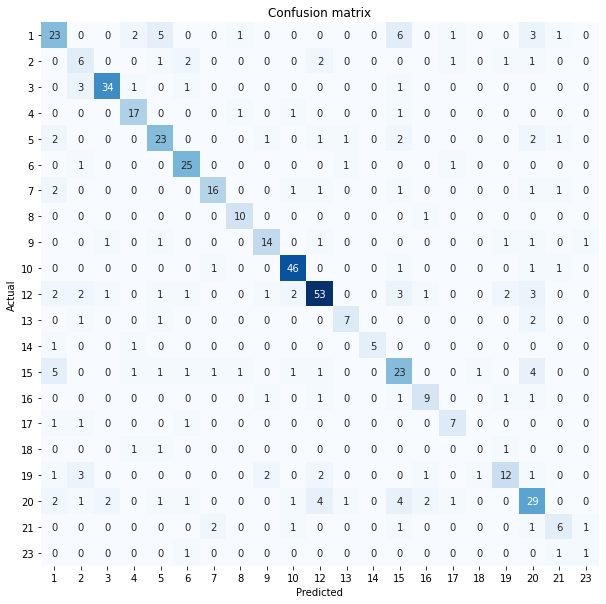

Feature trovati: 8468
Feature usati: 5000
--------------- Fold:  6 ---------------------

Accuracy: 0.65
Detail:
              precision    recall  f1-score   support

           1       0.47      0.57      0.52        42
           2       0.40      0.29      0.33        14
           3       0.82      0.90      0.86        40
           4       1.00      0.80      0.89        20
           5       0.47      0.58      0.52        33
           6       0.74      0.85      0.79        27
           7       0.70      0.67      0.68        24
           8       0.64      0.82      0.72        11
           9       0.65      0.75      0.70        20
          10       0.81      0.86      0.84        51
          12       0.74      0.67      0.70        72
          13       0.25      0.18      0.21        11
          14       0.71      0.71      0.71         7
          15       0.52      0.40      0.45        40
          16       0.64      0.50      0.56        14
          17       0.6

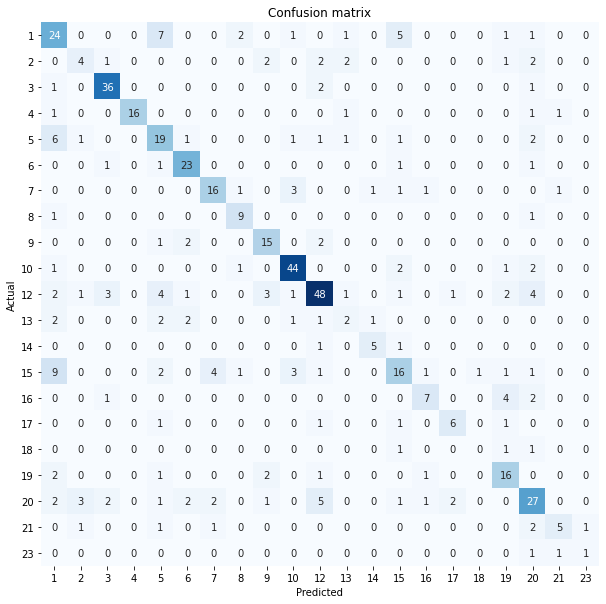

Feature trovati: 8399
Feature usati: 5000
--------------- Fold:  7 ---------------------

Accuracy: 0.69
Detail:
              precision    recall  f1-score   support

           1       0.55      0.64      0.59        42
           2       0.47      0.50      0.48        14
           3       0.85      0.85      0.85        41
           4       0.86      0.90      0.88        20
           5       0.65      0.75      0.70        32
           6       0.75      0.78      0.76        27
           7       0.74      0.83      0.78        24
           8       0.80      0.73      0.76        11
           9       0.88      0.71      0.79        21
          10       0.81      0.84      0.83        51
          12       0.67      0.72      0.69        72
          13       0.60      0.55      0.57        11
          14       0.57      0.57      0.57         7
          15       0.51      0.49      0.50        39
          16       0.90      0.69      0.78        13
          17       0.7

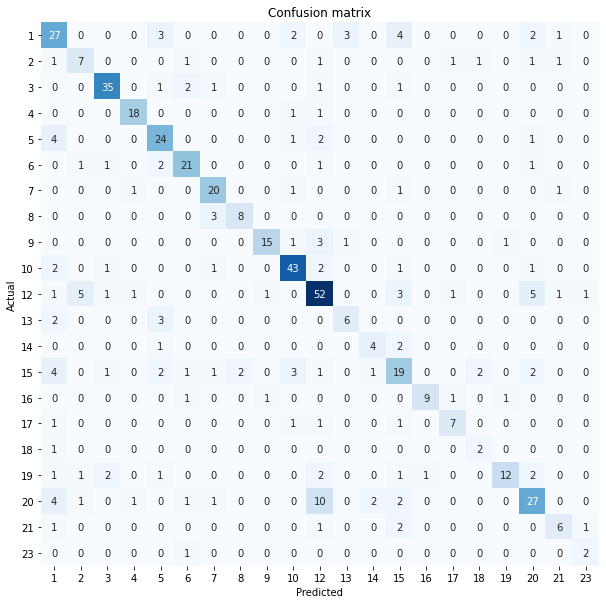

Feature trovati: 8469
Feature usati: 5000
--------------- Fold:  8 ---------------------

Accuracy: 0.71
Detail:
              precision    recall  f1-score   support

           1       0.51      0.52      0.52        42
           2       0.64      0.64      0.64        14
           3       0.95      0.90      0.92        41
           4       0.86      0.90      0.88        21
           5       0.68      0.66      0.67        32
           6       0.77      0.74      0.75        27
           7       0.68      0.71      0.69        24
           8       0.67      0.40      0.50        10
           9       0.85      0.81      0.83        21
          10       0.79      0.82      0.81        51
          12       0.77      0.79      0.78        72
          13       0.58      0.70      0.64        10
          14       0.80      0.50      0.62         8
          15       0.62      0.60      0.61        40
          16       0.70      0.54      0.61        13
          17       0.6

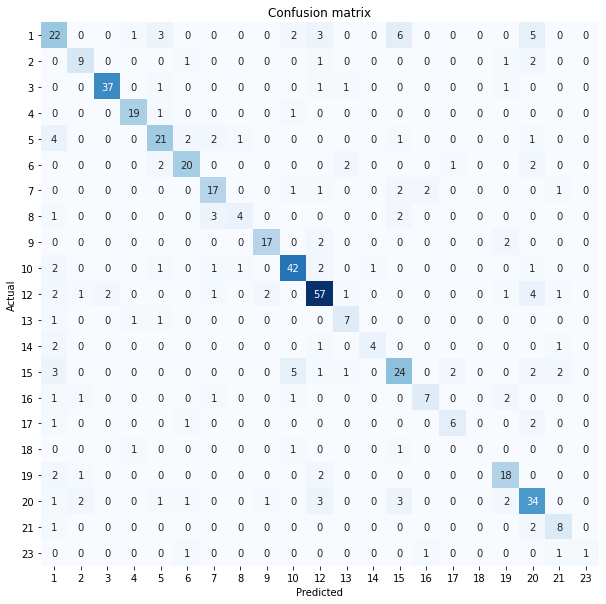

Feature trovati: 8435
Feature usati: 5000
--------------- Fold:  9 ---------------------

Accuracy: 0.73
Detail:
              precision    recall  f1-score   support

           1       0.61      0.74      0.67        42
           2       0.67      0.43      0.52        14
           3       0.84      0.90      0.87        41
           4       0.89      0.81      0.85        21
           5       0.78      0.66      0.71        32
           6       0.92      0.85      0.88        27
           7       0.77      0.83      0.80        24
           8       0.82      0.90      0.86        10
           9       0.89      0.81      0.85        21
          10       0.82      0.80      0.81        51
          12       0.71      0.88      0.78        72
          13       0.43      0.30      0.35        10
          14       0.75      0.75      0.75         8
          15       0.63      0.47      0.54        40
          16       0.82      0.69      0.75        13
          17       0.8

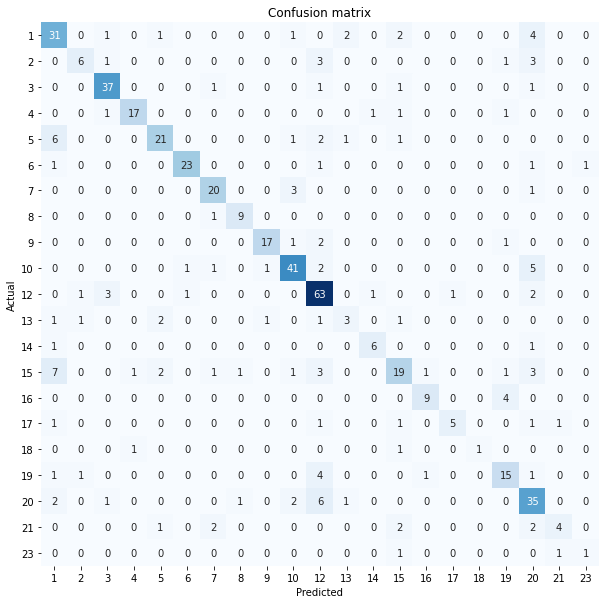

Feature trovati: 8425
Feature usati: 5000
--------------- Fold: 10 ---------------------

Accuracy: 0.72
Detail:
              precision    recall  f1-score   support

           1       0.62      0.69      0.65        42
           2       0.64      0.50      0.56        14
           3       0.95      0.88      0.91        40
           4       0.80      0.76      0.78        21
           5       0.85      0.72      0.78        32
           6       0.80      0.89      0.84        27
           7       0.73      0.67      0.70        24
           8       0.90      0.90      0.90        10
           9       0.65      0.85      0.74        20
          10       0.85      0.86      0.85        51
          12       0.75      0.79      0.77        72
          13       0.50      0.50      0.50        10
          14       0.83      0.62      0.71         8
          15       0.55      0.53      0.54        40
          16       0.71      0.77      0.74        13
          17       0.6

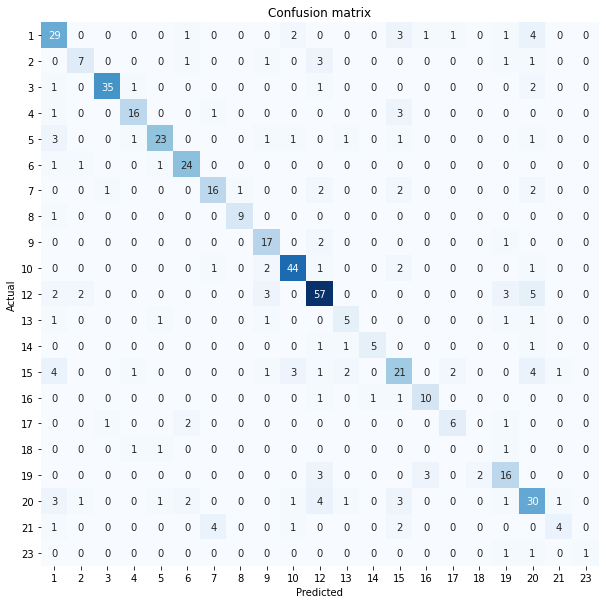

In [7]:
####### Setting up Cross-Validation #####
X=np.array(documents)
y=np.array(classes)
kfold = StratifiedKFold(n_splits=nfold,shuffle=True,random_state=1).split(X, y)

####### Define Variables for Metrics #####
accuracys = []
scores= []
metriche = np.zeros((nfold,4,len(np.unique(classes))))
target_names=list(map(str,np.unique(classes)))

####### Cross-Validation Loop ############

for k, (train, test) in enumerate(kfold):
    
   

    
    tfidf = TfidfVectorizer(strip_accents=strip_accents,
                        lowercase=False,
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_porter,
                        stop_words=stop,
                        min_df = 4
                       )

    
    final_features = tfidf.fit_transform(X[train])
    print("Feature trovati:",final_features.toarray().shape[1])
    
    ig=IG(k_features=number_of_feature)
    
   

   ########## Define Pipeline ########
    
    pipe_lr = make_pipeline(
                        tfidf,
                        ig,
                        PassiveAggressiveClassifier(C=C,tol=tol)
                        )
    
   #######################################

    pipe_lr.fit(X[train], y[train])
    y_pred=pipe_lr.predict(X[test])
    #y_prob=pipe_lr.predict_proba(X[test])

    
    ####### Compute Accuracy ##########
    accuracy = pipe_lr.score(X[test], y[test])
    accuracys.append(accuracy)
    
    ####### Compute Precision,Recall,F-Score ############
    score=precision_recall_fscore_support(y_true=y[test], y_pred=y_pred, average="weighted")
    scores.append(score[0:3])
    
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    print("Accuracy:",  round(accuracy,2))
    print("Detail:")
    print(metrics.classification_report(y[test], y_pred))
    
    dizionario=metrics.classification_report(y[test], y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<len(np.unique(classes)):
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break
    
    ## Plot confusion matrix
    conf_mat = confusion_matrix(y[test], y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cbar=False,cmap=plt.cm.Blues)
    ax.set(xlabel="Predicted", ylabel="Actual", xticklabels=target_names, 
           yticklabels=target_names, title="Confusion matrix")
    plt.yticks(rotation=0)
    
    print()
    
    plt.show()
    
    ## select observation
    #i = 0
    #txt_instance = X[test][i]
    ## check true value and predicted value
    #print("True:", y[test][i], "--> Pred:", y_pred[i], "| Prob:", round(np.max(y_prob[i]),2))
    ## show explanation
    #explainer = lime_text.LimeTextExplainer(class_names=target_names)
    #explained = explainer.explain_instance(txt_instance, 
                 #pipe_lr.predict_proba, num_features=6,top_labels=2)
    #explained.show_in_notebook(text=txt_instance, predict_proba=False)

    
arr = np.array(scores)

## Results Output

In [8]:
print("Overall results of the cross-validation procedure")
print()
print("Level 1")
print()

print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

print()
print("Level 2")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(len(np.unique(classes))):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f} +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")

Overall results of the cross-validation procedure

Level 1


CV accuracy: 69.53 +/- 2.45 max: 73.09

CV precision: 69.85 +/- 2.62 max: 73.57

CV recall: 69.53 +/- 2.45 max: 73.09

CV f1: 69.25 +/- 2.46 max: 72.54

Level 2

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 55.30 +/- 4.84  | 58.57 +/- 8.73  | 56.68 +/- 6.07  |   42.00  
   1    | 59.49 +/-15.80  | 51.62 +/-12.29  | 54.71 +/-12.87  |   14.30  
   2    | 86.48 +/- 5.99  | 86.84 +/- 3.39  | 86.48 +/- 3.10  |   40.30  
   3    | 84.37 +/-10.43  | 82.90 +/- 5.49  | 83.34 +/- 6.66  |   20.50  
   4    | 65.26 +/-10.00  | 66.66 +/- 6.49  | 65.70 +/- 7.27  |   32.40  
   5    | 80.19 +/- 5.46  | 82.76 +/- 4.71  | 81.32 +/- 3.73  |   27.30  
   6    | 77.12 +/- 5.91  | 77.37 +/- 9.63  | 77.05 +/- 6.99  |   23.90  
   7    | 73.05 +/- 8.61  | 78.36 +/-14.75  | 74.87 +/-10.56  |   10.70  
   8    | 74.89 +/-10.83  | 72.83 +/- 7.98  | 73.29 +/- 6.99  |   20.30  
   9    | 83.12 +/- 4.74  | 85.76 +/-